In [16]:
# Render our plots inline
%matplotlib inline

from requests import get
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from pandas import json_normalize

from mycbr_py_api import MyCBRRestApi as mycbr

# Basic Settings
Here you need to specify where the API is running. The default port is 8080, so if you only change the machine, specify it's name in "server"

In [7]:
server = 'localhost'
#server = 'hv-6066.idi.ntnu.no'

port = '8080'
base_url = 'http://' + server + ':' + port + '/'

obj = mycbr(base_url)

# Case Representation

These methods show how to fetch an existing case representation from the APO 
Get the model contents: concept, attribute, attribute types

In [35]:
def get_globalsim(concept):
    raw = pd.DataFrame(requests.get(base_url + 'concepts/' + concept + '/amalgamationFunctions').json()) 
    global_sim = pd.DataFrame.from_records(raw).values.tolist()
    return global_sim

def get_attribute_value_range(concept, attribute):
    raw = requests.get(base_url + 'concepts/' + concept + '/attributes/' + attribute).json()
    value_range = json_normalize(raw).range
    return value_range

# Case Base
Get the model contents: concept, casebase, attribute, attribute types

In [33]:
def get_casebases():
    raw = pd.DataFrame(requests.get(base_url + 'casebase/').json()) 
    casebases = pd.DataFrame.from_records(raw).values.tolist()
    return casebases

def get_instances(concept, casebase):
    raw = pd.DataFrame(requests.get(base_url + 'concepts/' + concept + '/casebases/' + casebase + '/cases').json()) 
    instances = raw.apply(pd.to_numeric, errors='coerce').fillna(raw)
    return instances

# Convenience Functions
- Create plots for case base content

In [34]:
def plot_numeric(data, attribute):
    ax = sns.histplot(data=data, x=attribute)
    ax.set(xlabel=attribute, ylabel='Count', title=attribute + ' (mean: '+data[attribute].astype(int).mean().__str__()+')')

def plot_symbolic(data, attribute):
    ax = sns.countplot(x=attribute, data=data, order = data[attribute].value_counts().index)
    ax.set(xlabel=attribute, ylabel='Dist', title=attribute)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Examples

The following cells will show how the fetch the content and configuration of the CBR via the Rest API.


In [11]:
obj.getAllConcepts()

['Car']

In [12]:
obj.getAllAttributes()

{'ZIP': 'IntegerDesc',
 'Speed': 'IntegerDesc',
 'Color': 'SymbolDesc',
 'CCM': 'IntegerDesc',
 'Car Code': 'IntegerDesc',
 'Miles': 'IntegerDesc',
 'Year': 'IntegerDesc',
 'Price': 'FloatDesc',
 'Doors': 'IntegerDesc',
 'Model': 'SymbolDesc',
 'Manufacturer': 'SymbolDesc',
 'Gas': 'SymbolDesc',
 'Body': 'SymbolDesc',
 'Power': 'IntegerDesc'}

In [13]:
obj.getAllAmalgamationFunctions()

['CarFunc']

In [18]:
get_attribute_value_range('Car', 'Body')  # returns the value range for an attribute (min/max for numbers; entire list for symbols)

0    [convertible, roadster, fastback, coupe, stati...
Name: range, dtype: object

In [19]:
obj.getCaseBaseIDs() # returns the list of existing case bases

['CaseBase0']

In [27]:
get_instances('Car','CaseBase0').head() # returns the contents of the case base

http://localhost:8080/concepts/Car/casebases/CaseBase0/cases


,similarity,caseID,Body,CCM,Car Code,Color,Doors,Gas,Manufacturer,Miles,Model,Power,Price,Speed,Year,ZIP
0,1,441_audi,sedan,2800,441,violet,4,gasoline,audi,29897,a6_2.8,193,49899,213,1995,8
1,1,108_audi,station_wagon,1600,108,turquoise,5,gasoline,audi,43858,a4_1.6,101,24699,183,1994,8
2,1,931_mercedes-benz,station_wagon,3200,931,gray,5,gasoline,mercedes-benz,32855,e_320,224,60799,241,1996,4
3,1,100_mercedes-benz,sedan,3000,100,yellow,4,diesel,mercedes-benz,18146,e_300_diesel,176,58499,224,1996,3
4,1,223_bmw,sedan,3500,223,dark_green,4,gasoline,bmw,24711,m3,320,73299,241,1997,2


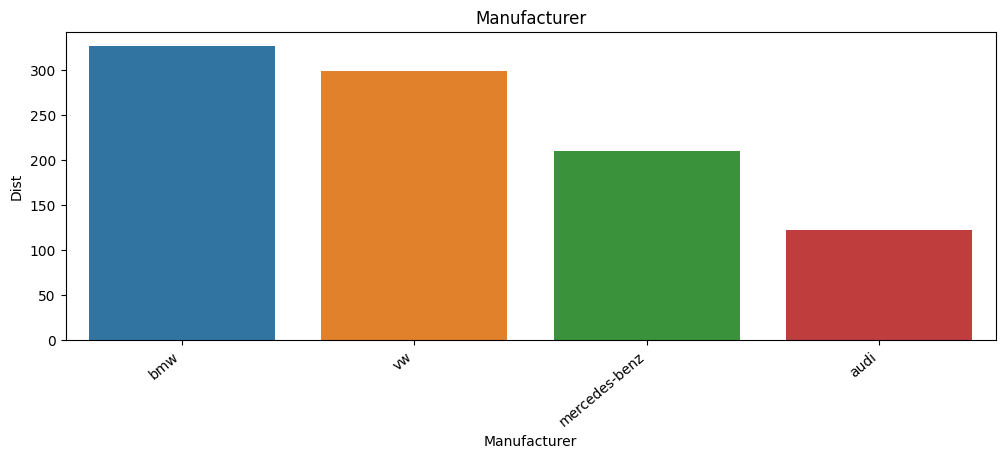

In [47]:
plt.rcParams["figure.figsize"] = (12, 4)
plot_symbolic(get_instances('Car','CaseBase0'), 'Manufacturer')

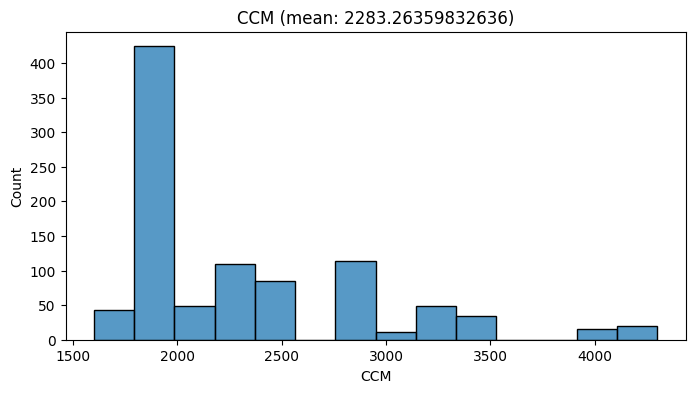

In [49]:
plt.rcParams["figure.figsize"] = (8, 4)
plot_numeric(get_instances('Car','CaseBase0'), 'CCM')

# Retrieval functions & visualizations
Example retrieval function that serve different purposes
- retrieve_k_sim_byID: This function uses the retrievalByID endpoint where a queryID is given (together with concept name, casebase name and k number of cases to be returned)

In [37]:
def retrieve_k_sim_byID(concept, casebase, amalgamationFct, queryID, k):
    raw = requests.get(base_url + 'concepts/' + concept + '/casebases/' + casebase + '/amalgamationFunctions/' + amalgamationFct +'/retrievalByCaseID?caseID=' + queryID + '&k=' + k ).json()
    results = pd.DataFrame.from_dict(raw.items())
    results.columns = ['caseID', 'similarity']
    results = results.apply(pd.to_numeric, errors='coerce').fillna(results).sort_values(by='similarity', ascending=False)
    return results

def plot_retrieve_k_sim_byID(data):
    plt.xticks(rotation=35)
    ax = sns.barplot(x='caseID', y="similarity", data=data)
    
def retrieve_k_sim_byID_content(concept, casebase, amalFct, queryID, k):
    raw = pd.DataFrame(requests.get(base_url + 'concepts/' + concept + '/casebases/' + casebase + '/amalgamationFunctions/' + amalFct + '/retrievalByCaseIDWithContent?caseID=' + queryID + '&k=' + k).json()) 
    results = raw.apply(pd.to_numeric, errors='coerce').fillna(raw).sort_values(by='similarity', ascending=False)
    results['similarity'] = results['similarity'].astype(float)
    returned_df = results.apply(pd.to_numeric, errors='coerce').fillna(results)
    return results

def plot_retrieved_scatter(data, x_attr):
    plt.xticks(rotation=35)
    ax = sns.scatterplot(x=x_attr, y='similarity', data=data)



# Retrieval Examples

In [40]:
# Find most similar cases 
result_caseIDs = retrieve_k_sim_byID('Car','CaseBase0', 'CarFunc', '441_audi', '60')
result_caseIDs.head(10)

,caseID,similarity
0,441_audi,1.0
1,726_audi,0.591756
2,366_audi,0.588839
3,240_audi,0.58242
4,279_audi,0.557674
5,317_audi,0.548449
6,641_audi,0.545529
7,633_audi,0.536532
8,907_audi,0.531384
9,241_audi,0.53077


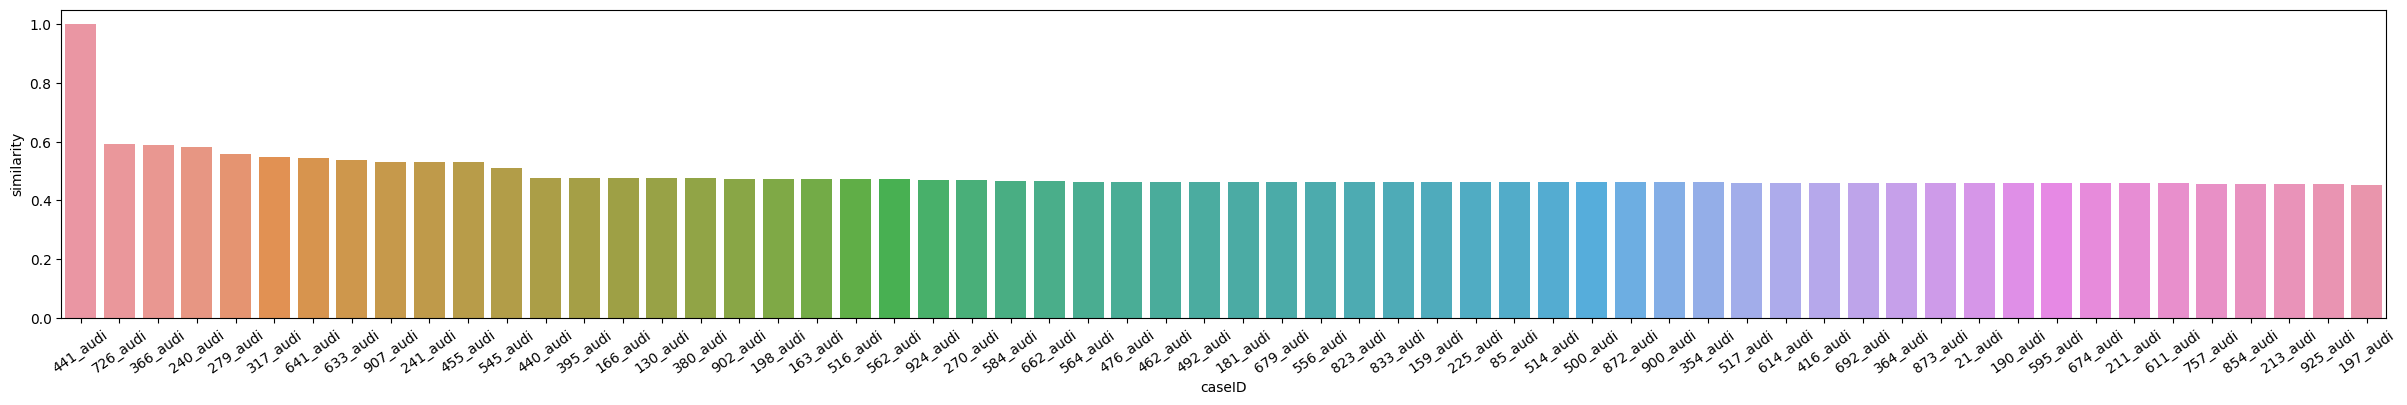

In [41]:
# Plot most similar cases - this requires result_caseIDs from the previous cell (called retrieve_k_sim_byID(..))
plt.rcParams["figure.figsize"] = (30, 4)
plot_retrieve_k_sim_byID(result_caseIDs)

In [42]:
# Find most similar cases and get the full case content for them
result_fullCases = retrieve_k_sim_byID_content('Car','CaseBase0', 'CarFunc', '441_audi', '60')
result_fullCases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   similarity    60 non-null     float64
 1   caseID        60 non-null     object 
 2   Body          60 non-null     object 
 3   CCM           60 non-null     int64  
 4   Car Code      60 non-null     int64  
 5   Color         60 non-null     object 
 6   Doors         60 non-null     int64  
 7   Gas           60 non-null     object 
 8   Manufacturer  60 non-null     object 
 9   Miles         60 non-null     int64  
 10  Model         60 non-null     object 
 11  Power         60 non-null     int64  
 12  Price         60 non-null     int64  
 13  Speed         60 non-null     int64  
 14  Year          60 non-null     int64  
 15  ZIP           60 non-null     int64  
dtypes: float64(1), int64(9), object(6)
memory usage: 8.0+ KB


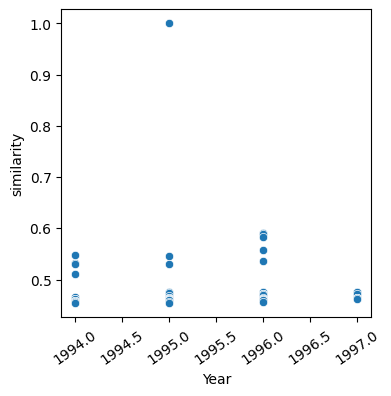

In [44]:
def plot_retrieved_scatter(data, x_attr):
    plt.xticks(rotation=35)
    ax = sns.scatterplot(x=x_attr, y='similarity', data=data)
    
# Create a scatter plot showing the similarity vs. a specified attribute
plt.rcParams["figure.figsize"] = (4, 4)
plot_retrieved_scatter(result_fullCases, 'Year')

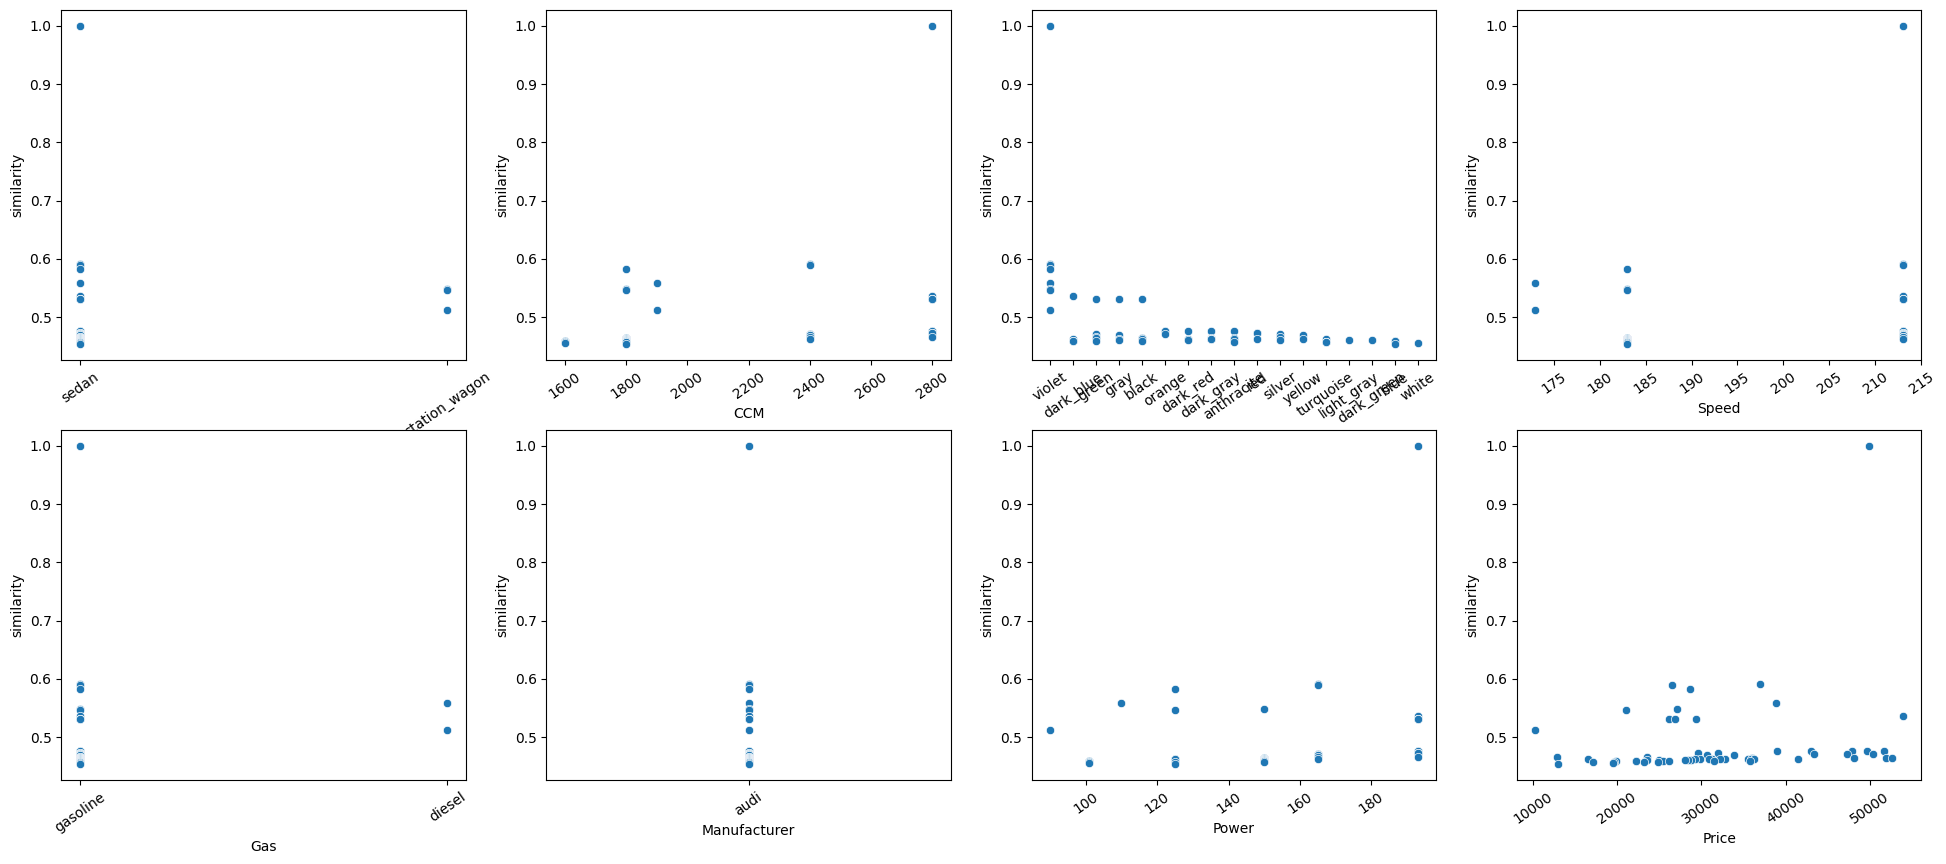

In [46]:
fig = plt.figure(figsize=(24,10))

plt.subplot(2, 4, 1)
plot_retrieved_scatter(result_fullCases, 'Body')

plt.subplot(2, 4, 2)
plot_retrieved_scatter(result_fullCases, 'CCM')

plt.subplot(2, 4, 3)
plot_retrieved_scatter(result_fullCases, 'Color')

plt.subplot(2, 4, 4)
plot_retrieved_scatter(result_fullCases, 'Speed')

plt.subplot(2, 4, 5)
plot_retrieved_scatter(result_fullCases, 'Gas')

plt.subplot(2, 4, 6)
plot_retrieved_scatter(result_fullCases, 'Manufacturer')

plt.subplot(2, 4, 7)
plot_retrieved_scatter(result_fullCases, 'Power')

plt.subplot(2, 4, 8)
plot_retrieved_scatter(result_fullCases, 'Price')

plt.show()